# Ramsey King
# DSC 550 - Data Mining
# October 24, 2021
# Term Project Milestone 3

### My term project will consist of being able to guess the main topic of sermons given by members of The Church of Jesus Christ of Latter Day Saints as defined by the designated topic assigned to it at speeches.byu.edu.  The ability to search for sermons by topic on this website is available.  While this specific case is not a business use case of data mining, there are many business use cases for being able to identify text by topic or keyword (i.e. www.google.com).  
### For purposes of this assignment, being able to quickly find topic related sermons is beneficial to members of the Church of Jesus Christ.  On occasion, members of the church are asked to give a sermon of their own on various topics, and having the ability to go to a resource and search the assigned topic by keyword helps to generate discussion points and give guidance as to what is appropriate to discuss.  For this project, we will limit the topics as defined by speeches.byu.edu. to give us an initial dataset of 800 rows before processing.  The topics and the count of the number of sermons given (as of October 4th, 2021) are: Life (108), Jesus Christ (106), Faith (100), Learning (97), Service (73), Discipleship (67), Righteousness (67), Divine Potential (66), Love (66), Adversity (57), Trials (56), Revelation (55), and Missionary Work (53).  This should provide enough data to work with but if there is a need, additional topics will be included to help with the corpus.  

In [80]:
# Retrieve talks from topics page using BeautifulSoup

from bs4 import BeautifulSoup as bs
import requests
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

Now that we have BeautifulSoup imported, we will gather the links on the speeches.byu.edu website based on the topics listed above (Faith, Learning, Service, etc.).  

In [81]:
# Get list of urls for each of the topics

url = "https://speeches.byu.edu/topics/"

url_list = [
    'life/', 'jesus-christ/', 'faith/', 'learning/', 'service/', 'discipleship/', 'righteousness/', 
    'divine-potential/', 'love/', 'adversity/', 'trials/', 'revelation/', 'missionary-work/'
]

links = []
new_links = []
# some of the links are repeated with '?M=V' and '?M=A' and those will be removed so we can have a unique set of links to pull talk information from.
for u in url_list:

    response = requests.get(url+u)
    html = response.content
    video = '?M=V'
    soup = bs(html, "lxml")
    for link in soup.findAll("a", attrs={'href': re.compile("^https://speeches.byu.edu/talks/[\D+]")}):
        links.append(link.get('href').replace(video, ''))

    audio = '?M=A'
    for link in links:
        new_link = link.replace(audio, '')
        new_links.append(new_link)
    new_links = list(set(new_links))



Now that the links have been gathered into a list, we will use this list to retrieve the individual sermon/talk/speech text from the respective link.  On a specific speech page, the following information will be gathered:
 - Speaker name
 - Talk title
 - Assigned topic
 - Date when the talk was given
 - The speaker's title (if they have a certain position within The Church of Jesus Christ of Latter Day Saints, Brigham Young University, etc.  If there is no position or title listed for the speaker, we will return 'Title Not Found')
 - The talk text

 This information will be combined into a dataframe for analysis.  This information will also be combined into a csv file in case work needs to be completed offline.

In [82]:
'''Retrieves talk text from each of the urls using beautiful soup.  Information such as the talk/sermon text, title, topic, date, and speaker will be retreived
and put into a dataframe.  A csv file will also be saved due to the time it takes to run or in case we need to work offline.'''
talk_text = []
title_text = []
topics = []
dates = []
speakers = []
speaker_position = []

for link in new_links:
    url = link
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    temp_list = []

    link_splitter = link.split('/')
    speakers.append(link_splitter[4].replace('-', ' '))

    result = soup.find('p', class_='single-speech__speaker-subtext single-speech__speaker-position')
    speaker_position.append(result.text if result else 'Title Not Found')

    for div in soup.find_all('div', class_='single-speech__content'):
        talk_text.append(div.get_text(strip=True))
    for h1 in soup.find_all('h1', class_='single-speech__title'):
        title_text.append(h1.get_text(strip=True))        
    for p in soup.find_all('p', class_='single-speech__speaker-subtext single-speech__date'):
        dates.append(p.get_text(strip=True))
    for p in soup.find_all('p', class_='single-speech__related-tag'):
        temp_list.append(p.get_text(strip=True))
        temp_str = ','.join(temp_list)
    topics.append(temp_str)


dict = {'titles': title_text , 'speaker': speakers, 'speaker_position': speaker_position , 'date': dates, 'talks': talk_text, 'topics': topics, }
df = pd.DataFrame(dict)
# df.to_csv('talks.csv')

Now that the talk information has been combined into a dataframe, we can begin pre-processing and gathering initial statistical information.  To begin, we will get the word count of each talk and place it in one of our columns.

In [83]:
# get word count of each talk
df['word_count'] = df['talks'].apply(lambda x: len(re.findall(r'\w+', x)))

Some talks have multiple topic associated with them on their webpage where the talk text was retrieved.  For purposes of this exercise (and project), we will take the first topic that is listed on the page and that will be our defining topic that will be used for analysis and modeling.  We will also create time columns (Month, Year, and month as an integer) to see if insights can be gained from them. 

In [84]:
# reduce the topic to the ones selected from our original selection ('life', 'jesus-christ', 'faith', 'learning', 'service')
from datetime import datetime
# the single_topic function takes the list of topics in the 'topics' column and will return the first topic it finds in the 'topic_selection_list'
def single_topic(dataframe_topics):
    column = [word for word in dataframe_topics.split(',')]
    the_string =  ', '.join([val for ind, val in enumerate(topic_selection_list) if val in column])
    return the_string.split(',')[0]

# removes the '/' from the url list and '-' from topics containing dashes such as 'jesus-christ'
topic_selection_list = [x[:-1].replace('-', ' ') for x in url_list]
df['topics'] = df['topics'].apply(lambda x: x.lower())
df['topic_singular'] = df['topics'].apply(single_topic)

# remove quotations ("") and all other punctuation from titles
df['titles'] = df['titles'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# create separate month and year column and create a number column representing the month 
df['month'] = df['date'].apply(lambda x: x.split(' ')[0])
# df['month_dt'] = df['month'].apply(lambda x: datetime.strptime(x, '%B'))
df['month_dt'] = pd.to_datetime(df['month'], format='%B')
df['year'] = df['date'].apply(lambda x: x.split(' ')[2]).astype(int)

def month_to_int(month_string):
    month_dictionary = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }

    return month_dictionary.get(month_string)
    
df['month_number'] = df['month'].apply(month_to_int)

# get the dimensions of the dataset
df.shape


(809, 12)

Some of the webpages that data was scraped from did not have the talk text on the page.  Those will be removed from our dataframe.

In [85]:
# Remove the talks that do not contain any data.
print(df.shape)
df = df[df['talks'].str.contains('for this speech is unavailable')==False]
df.shape

(809, 12)


(654, 12)

At this time, we have an initial dataframe of information that we begin doing some statistical analysis on.  We will take a look at the dataframe.

In [86]:
# Take a peek at the data
df.reset_index(inplace = True, drop = True)
first_column = df.pop('topic_singular')
df.insert(0, 'topic_singular', first_column)
df.head(7)

,topic_singular,titles,speaker,speaker_position,date,talks,topics,word_count,month,month_dt,year,month_number
0,service,Serve the Lord with Gladness,nora kay nyland,Title Not Found,"April 30, 2004",I had been on my mission in Taiwan only a few ...,"service,women’s conference",3664,April,1900-04-01,2004,4
1,life,Ships Are Safe in the Harbor,claudio r m costa,Title Not Found,"November 2, 2010","Years ago, while visiting one of our institute...","life,opportunity",3292,November,1900-11-01,2010,11
2,service,Go Forth and Serve,robert d hales,Of the Quorum of the Twelve Apostles,"April 27, 2006","Beloved Brigham Young University graduates, th...",service,2569,April,1900-04-01,2006,4
3,divine potential,The Highest in Us,truman g madsen,Professor of Philosophy at Brigham Young Unive...,"March 3, 1974",May I begin with an incident from our history ...,"divine nature,divine potential",4606,March,1900-03-01,1974,3
4,learning,Ever Learning and Ever Improving,cecil o samuelson,President of Brigham Young University,"August 14, 2003","Brothers, sisters, and friends, it is my great...",learning,1092,August,1900-08-01,2003,8
5,service,Learning the Healers Art,elaine s marshall,Dean of the BYU College of Nursing,"October 8, 2002",This year the Brigham Young University College...,"compassion,healing,service,podcast: by study a...",3582,October,1900-10-01,2002,10
6,life,Journey of the Soul Anchors of the Heart,len b novilla,Associate Professor in the Department of Healt...,"February 1, 2011","Brothers and sisters, aloha! Don’t worry. I kn...","life,trials,collection: overcoming adversity,p...",4192,February,1900-02-01,2011,2


Some initial statistical information.

In [87]:
# We want to get some inital statistical information from the dataset.
print("Describe Data")
print(df.describe())
print("Summarized Data")
print(df.describe(include=['O']))

Describe Data
         word_count         year  month_number
count    654.000000   654.000000    654.000000
mean    4068.088685  2000.870031      6.186544
std     1501.653363    13.989164      3.265027
min       13.000000  1950.000000      1.000000
25%     3369.500000  1990.000000      3.000000
50%     4133.500000  2004.000000      6.000000
75%     4974.500000  2012.000000      9.000000
max    10827.000000  2021.000000     12.000000
Summarized Data
       topic_singular             titles            speaker speaker_position  \
count             654                654                654              654   
unique             13                648                398              187   
top              life  Go Forth to Serve  cecil o samuelson  Title Not Found   
freq               89                  4                 16              187   

                  date                                              talks  \
count              654                                               

Based on the statistics, there is a talk that is duplicated.  We will find that talk and remove it from the dataset.

In [88]:
df = df[df['speaker'].str.contains('gordon b hinckley_greatest of these love')==False]
df.shape


(653, 12)

Initial plots will be created to see if any insights can be gained.  We will plot the following:
- talk word counts
- year the talk was given
- month the talk was given

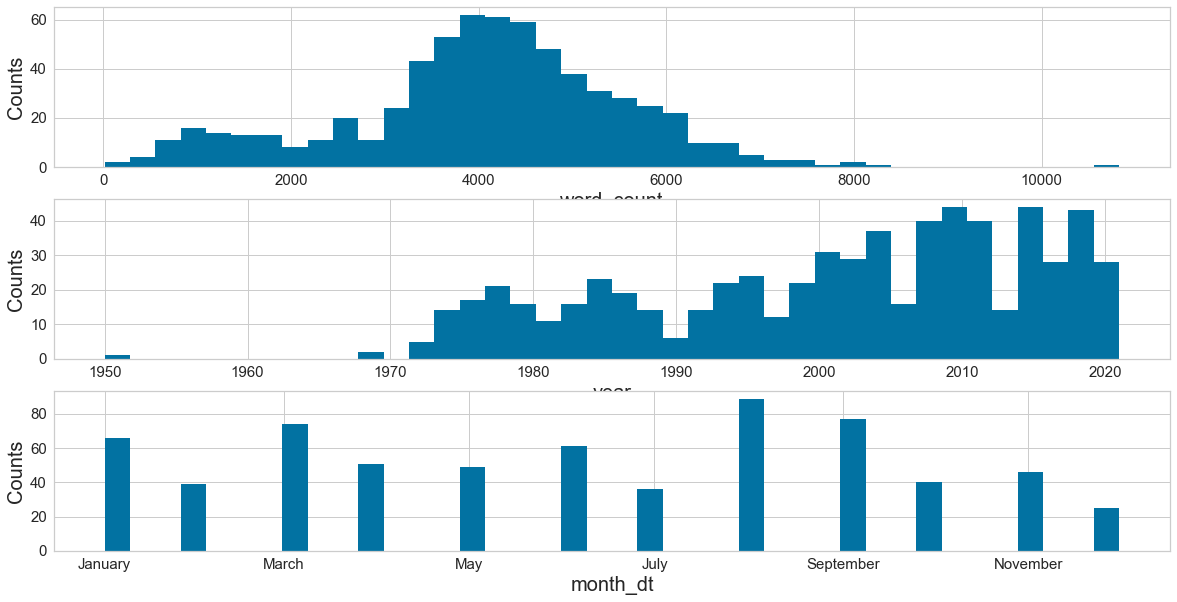

In [89]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 3, ncols = 1)

# Specify the features of interest
num_features = ['word_count', 'year', 'month_dt']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx == 2:
        date_form = DateFormatter('%B')
        ax.xaxis.set_major_formatter(date_form)
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)    
    else:
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)

plt.show()

Based on the plot above, we can make a few observations:  
- The overall number of talks increased as time has gone on.
- August seems to be a popular month for people to give talks at Brigham Young University (suggesting that it coincides with the beginning of the school year)

The next plot will give us count by topic.

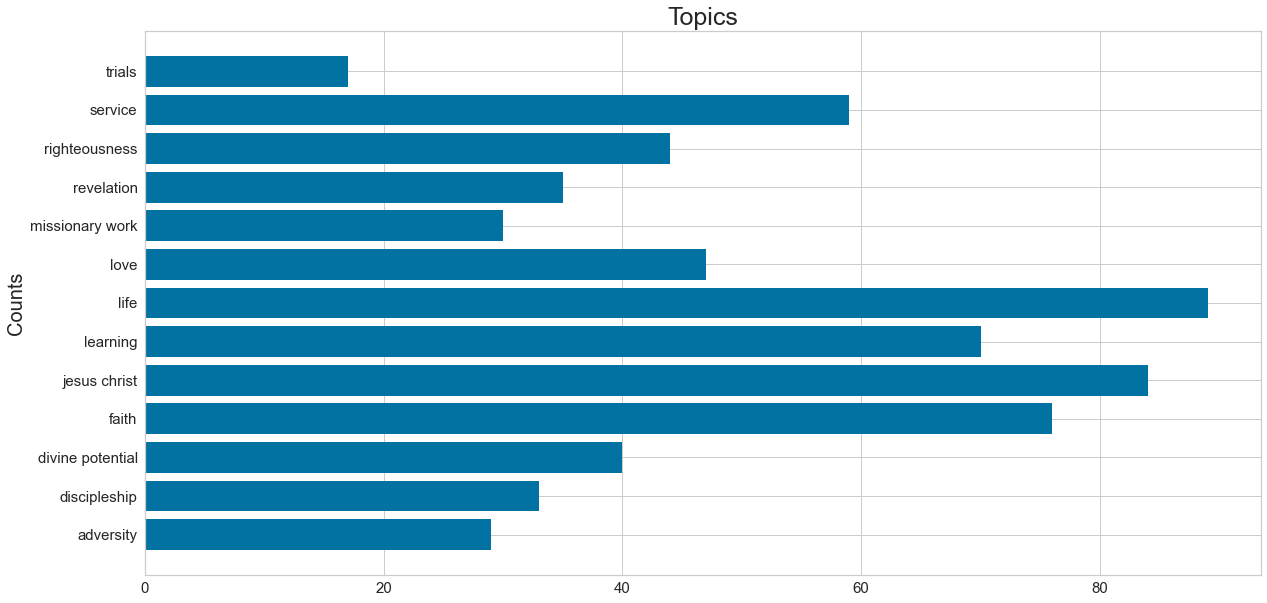

In [90]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
X_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['topic_singular']
Y_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes.barh(X_Topics, Y_Topics)
axes.set_title('Topics', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)

plt.show()


Observations from the topics bar chart:
- Jesus Christ and Life are the most popular topics (of the most popular topics).  
- All of the most popular seem to fall in line with a private religious university

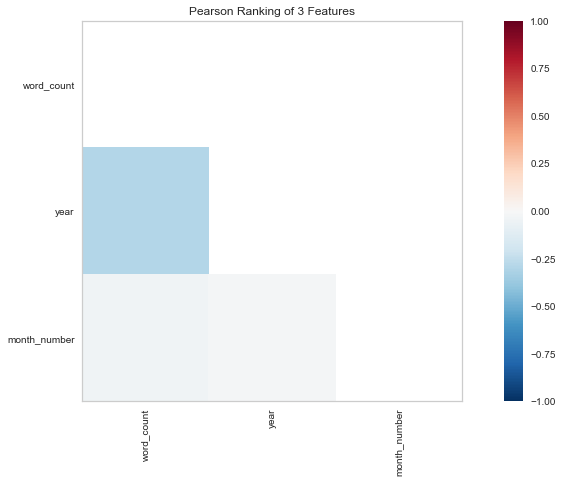

In [91]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['word_count', 'year', 'month_number']

# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

A few observations from the Pearson Ranking matrix plot:
- As the years increase (become more recent to our day), the speakers seem to have more to say (use more words).
- The later in the year, the less sermons are given.  Maybe this is due to July being a summer month with not a lot of the student body present on campus, and December has winter break.

The next plot will show a bar chart of the most popular topics (Faith, Jesus Christ, Learning, Life, and Service) and what month they were given.

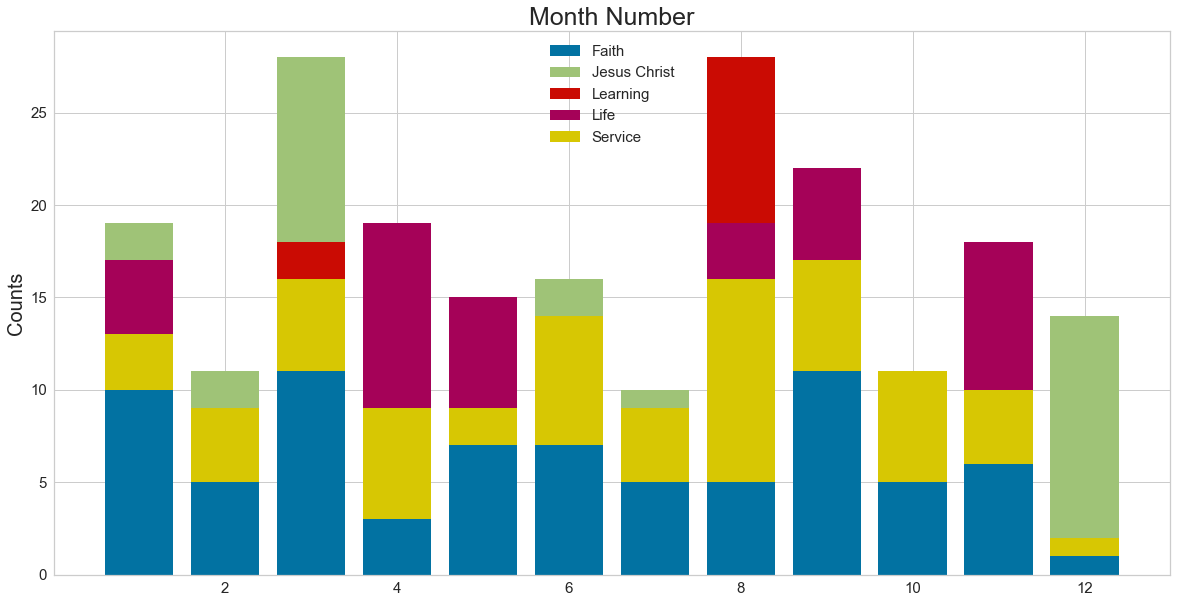

In [92]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visualizer
month_number_faith = df[df['topic_singular']=='faith']['month_number'].value_counts()

month_number_jc = df[df['topic_singular']=='jesus christ']['month_number'].value_counts()
month_number_jc = month_number_jc.reindex(index = month_number_faith.index)

month_number_learning = df[df['topic_singular']=='learning']['month_number'].value_counts()
month_number_learning = month_number_learning.reindex(index = month_number_faith.index)

month_number_life = df[df['topic_singular']=='life']['month_number'].value_counts()
month_number_life = month_number_life.reindex(index = month_number_faith.index)

month_number_service = df[df['topic_singular']=='service']['month_number'].value_counts()
month_number_service = month_number_service.reindex(index = month_number_faith.index)
# make the bar plot
p1 = axes.bar(month_number_faith.index, month_number_faith.values)
p2 = axes.bar(month_number_jc.index, month_number_jc.values, bottom=month_number_faith.values)
p3 = axes.bar(month_number_learning.index, month_number_learning.values, bottom=month_number_faith.values)
p4 = axes.bar(month_number_life.index, month_number_life.values, bottom=month_number_faith.values)
p5 = axes.bar(month_number_service.index, month_number_service.values, bottom=month_number_faith.values)
# date_form = DateFormatter('%B')
# axes.xaxis.set_major_formatter(date_form)
axes.set_title('Month Number', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)
axes.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Faith', 'Jesus Christ', 'Learning', 'Life', 'Service'), fontsize = 15)

plt.show()


The following observations can be made from the chart above:

- August is the most popular month for talks, with an overwhelming majority of the learning topics being contained there.
- December is a popular month to discuss Jesus Christ (more than likely due to Christmas).
- Faith and Service is a common theme no matter the time of year.
- Jesus Christ as a topic is popular in March (perhaps due to Easter?).

It will be interesting as we continue on with this project how these variables will play into the predictability of the project.

In Milestone 2, you should drop any features that are not useful for your model building. You should explain and justify why the feature dropped is not useful. You should address any missing data issues. Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary. Explain your process at each step. You can use any methods/tools you think are most appropriate. Again, keep in mind that this may look very different from what is done in the Titanic tutorial case study. You should do what makes sense for your project. Be careful to avoid data snooping in these steps.

Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary.

We will now create dummy variables for the categorical designations in the topic_singular column that will be later used for model analysis.  Instead of using a dictionary to assign values to the categories (i.e. adversity = 1, divine potential = 2, etc.), we will use the get_dummies section so that the model will not give more importance to a higher number.

In [93]:
# Assign the singular topics an number ID for model analysis

# df = pd.get_dummies(df, prefix='topic_singular', columns=['topic_singular'])
df.head(7)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 653
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   topic_singular    653 non-null    object        
 1   titles            653 non-null    object        
 2   speaker           653 non-null    object        
 3   speaker_position  653 non-null    object        
 4   date              653 non-null    object        
 5   talks             653 non-null    object        
 6   topics            653 non-null    object        
 7   word_count        653 non-null    int64         
 8   month             653 non-null    object        
 9   month_dt          653 non-null    datetime64[ns]
 10  year              653 non-null    int64         
 11  month_number      653 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 66.3+ KB


In Milestone 3, you will begin the process of model selection and evaluation. In addition, write step-by-step instructions for performing the model evaluation and selection part of your case study.

In Milestone 3, you should build and evaluate at least one model. You can use any methods/tools you think are most appropriate, but you should explain/justify why you are choosing the model(s) and evaluation metric(s) you choose. It is important to think about what type of model and metric makes sense for the context of your problem. If you are familiar with hyperparameter tuning, this would also be a great addition to your project.

Write a short overview/conclusion of the insights gained from your model building/evaluation.

In [94]:
# Lower case, remove stop words, and stem the talk text

df['talks_lowered'] = df['talks'].apply(lambda x: x.lower())
df['talks_lowered'][1]

'years ago, while visiting one of our institute buildings, i saw a beautiful painting on the wall. it was of a 16th-century ship with the sails tied to the mast, anchored safely in the harbor. at the bottom of the painting was the inscription “a ship is safe in harbor, but that’s not what ships are for.”the phrase was in my native tongue of portuguese. in that language the verbto behas two translations. one translation is the verbser,and it means something that is fixed or permanent. the other translation isestar,and it is used to describe something that is transitory. for example, for me to state in portuguese, “i am the son of nelson costa,” i would use the verbser,because i am his son and i will continue to be his son forever. it is unchangeable.i am speaking to you now, and in about 20 minutes i will stop. to explain this in portuguese, i would use the verbestar.the verb used in the inscription on the painting wasestar,meaning that the ship, although anchored, was in the harbor tem

Prior to model selection, we will tokenize our talks with sentences, words, and part-of-speech tagging.

In [95]:
# tokenization of the speeches into sentences.
from nltk.tokenize import sent_tokenize

df['sentence_tokenize'] = df['talks'].apply(lambda x: sent_tokenize(x))

In [96]:
# tokenization of the speeches into words
from nltk.tokenize import word_tokenize
df['word_tokenize'] = df['talks'].apply(lambda x: word_tokenize(x))

In [ ]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
data = []

for i in range(df.shape[0]):
    text = df.iloc[i,5]
    talk_processed_list = []
    for word in text:
        if word not in set(stopwords.words('english')):
            talk_processed_list.append(stemmer.stem(word))
    proc_talk = " ".join(talk_processed_list)
    data.append(proc_talk)

print(data[1], len(data))

In [ ]:
# pos 
import nltk
# nltk.download('averaged_perceptron_tagger')

df['word_pos'] = df['word_tokenize'].apply(lambda x: nltk.pos_tag(x))

From this point, there are a couple of things that I need to do:
- Look at the image that you saw this morning regarding which model to try.  Explain why you are using this model by showing how you followed the flow diagram to get to the chosen model.
- Look up a website that walks through the process of a text classification model and mimic it.
- Once these things are working, I will need to re-run the notebook to eliminate one of the charting errors up top.
- Hopefully if all runs well, I can talk about the accuracy, precision, F1, and other parameters on the project.

In [ ]:
# from CharlesRajendran TextClassification github
# https://github.com/CharlesRajendran/TextClassification/blob/master/classifier.py

# creating the feature matrix
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
y = df.iloc[:, 0]
print(X.shape, y)

In [ ]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

In [ ]:
# predict class

y_pred = classifier.predict(X_test)

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cm)
print()
print(cr)
print()
print(accuracy)